In [1]:
!pip install -Uqq fastbook

# Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.

2. Complete all the steps in this chapter using the full MNIST datasets (for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome obstancles you'll meet on the way.

## LearnerV0

In this section, we'll make an implementation of the training loop described in this chapter and then use it to train a full MNIST classifier. We will use `fastai` building blocks wherever possible (except, of course, for the implementation of the training loop itself).

This means, for example, that we'll make use of the `DataBlock` and `ImageBlock`/`CategoryBlock` APIs, to build a single network that classifies all digit classes.

In [2]:
import torch
from tqdm import tqdm

import fastai.vision.all as fai
from fastai.vision.all import nn, F, tensor

In [3]:
from pathlib import Path
path = fai.untar_data(fai.URLs.MNIST)
Path.BASE_PATH = path

In [4]:
path.ls()

(#2) [Path('training'),Path('testing')]

In [5]:
mnist_block = fai.DataBlock(
    blocks=(fai.ImageBlock(cls=fai.PILImageBW), fai.CategoryBlock()),
    get_items=fai.get_image_files,
    get_y=fai.parent_label,
    splitter=fai.GrandparentSplitter(train_name='training', valid_name='testing')
)

loaders = mnist_block.dataloaders(path, shuffle=True)

Notice that the `shuffle` parameter only applies to the train dataset:

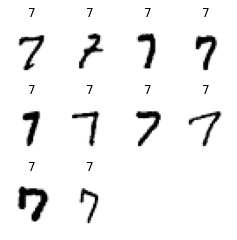

In [6]:
loaders.valid.show_batch(max_n=10, figsize=(4, 4))

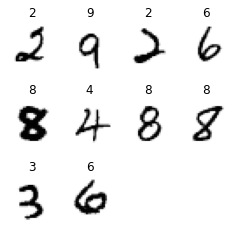

In [7]:
loaders.train.show_batch(max_n=10, figsize=(4, 4))

In [8]:
x, y = loaders.one_batch()
x.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [9]:
from collections import defaultdict

import numpy as np
import pandas as pd
import torch

from tqdm import tqdm
from IPython.display import clear_output, display
    
class LearnerV0:
    def __init__(
        self, 
        dataloaders, 
        model, 
        loss_function,
        optimizer_builder=fai.SGD, 
        metrics_functions=[fai.accuracy]
    ):
        self.dataloaders = dataloaders
        # ensure the model parameters are loaded on the GPU
        self.model = model.cuda()
        self.loss_function = loss_function
        self.optimizer_builder = optimizer_builder
        self.metrics_functions = metrics_functions
        
        self.optimizer = None # to be built at training time
        self.results_table = []
        
    def fit(self, epochs=1, learning_rate=1e-3, with_validation=True):
        self.optimizer = self.optimizer_builder(
            self.model.parameters(), lr=learning_rate
        )
        self.results_table = []
        for epoch in range(epochs):
            training_loss = self.train_epoch(self.model, self.dataloaders.train)
            validation_loss, metrics = None, []

            if with_validation:
                validation_loss, metrics = self.validate_epoch(
                    self.model, self.dataloaders.valid)
                
            self.report_epoch_results(epoch, {
                "validation_loss": validation_loss,
                "training_loss": training_loss,
                "metrics": metrics
            })
            
    def train_epoch(self, model, dataset):
        losses = []
        for inputs, targets in tqdm(dataset):
            # ensure that the inputs are on the GPU
            predictions = model(inputs.cuda())
            batch_loss = self.loss_function(predictions, targets.cuda())
            losses.append(batch_loss)
            
            # compute gradients
            batch_loss.backward()
            self.update_parameters()
            
        return tensor(losses).mean()
    
    def validate_epoch(self, model, validation_set):
        losses = []
        metrics = defaultdict(list)
        
        for inputs, targets in tqdm(validation_set):
            # during validation we don't need to compute gradients
            with torch.no_grad():
                predictions = model(inputs.cuda())
                batch_loss = self.loss_function(predictions, targets.cuda())
                losses.append(batch_loss)
                
            for index, metric_function in enumerate(self.metrics_functions):
                metrics[index].append(metric_function(predictions, targets.cuda()))
                
        return (
            tensor(losses).mean(), 
            [tensor(metrics[index]).mean() for index in range(len(metrics))]
        )
    
    def report_epoch_results(self, epoch, results):
        row = {'epoch': epoch + 1}

        training_loss = results.get('training_loss')
        if training_loss:
            row['training_loss'] = round(training_loss.item(), 6)
            
        validation_loss = results.get('validation_loss')
        if validation_loss:
            row['validation_loss'] = round(validation_loss.item(), 6)
            
        metrics = results.get('metrics', [])
        for index, value in enumerate(metrics):
            metric_name = self.metrics_functions[index].__name__
            row[metric_name] = round(value.item(), 4)

        # make believe that the table is being updated "live"
        clear_output(wait=True)
        self.results_table.append(row)
        display(pd.DataFrame.from_dict(self.results_table))
        
    def update_parameters(self):
        self.optimizer.step()
        self.optimizer.zero_grad()


In [10]:
def make_linear_classifier_model():
    return nn.Sequential(
        fai.Flatten(),
        nn.Linear(in_features=28*28, out_features=10),
        nn.Softmax(dim=1)
    )

In [11]:
learner = LearnerV0(
    loaders, make_linear_classifier_model(), 
    loss_function=F.cross_entropy, 
    optimizer_builder=fai.Adam
)
learner.fit(epochs=3, learning_rate=1e-2)

,epoch,training_loss,validation_loss,accuracy
0,1,1.582325,1.548468,0.9167
1,2,1.546310,1.539045,0.9255
2,3,1.540356,1.539433,0.9240


In [12]:
learner = fai.Learner(
    loaders, make_linear_classifier_model(), 
    loss_func=F.cross_entropy, metrics=fai.accuracy
)
learner.fit(3, lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.552610,1.548092,0.919200,00:15
1,1.549849,1.542009,0.922600,00:15
2,1.539303,1.537935,0.926500,00:15


### Research Questions
Our implementation of the training loop `LearnerV0` consistently provides a lower validation accuracy (~84%) after 15 epochs, whereas FastAI's version consistently achieves ~95% validation accuracy. How can we explain this?

🕵️

After examining the implementation of `Learner` the first obvious difference is that by default it uses the `Adam` optimizer, as opposed to plain `SGD` (the default in `LearnerV0`). Running `LearnerV0` with the `Adam` optimizer proves this is indeed the case.

## Ensemble of Binary Classifiers
In this section, we'll experiment building a bunch of binary classifiers and using a simple voting mechanism (just taking the classifier with the highest probability for its category).

Goals for this experiment include:

+ Find out whether we can build a more accurate classifier this way
    + Intuitively, it might seem that it's easier to learn binary classifiers
+ Figure out whether it takes less training time overall
    + One obvious advantage of this approach is that it's easy to parallelize as each classifier can be trained independently.

### Loading Data by Hand

Also, just for kicks, we'll avoid using FastAI helpers and build the data loaders from scratch.

In [13]:
(path/'training').ls().sorted()

(#10) [Path('training/0'),Path('training/1'),Path('training/2'),Path('training/3'),Path('training/4'),Path('training/5'),Path('training/6'),Path('training/7'),Path('training/8'),Path('training/9')]

In [14]:
img = fai.Image.open((path/'training'/'2').ls()[10])
img

In [15]:
tensor(img).shape

torch.Size([28, 28])

In [16]:
def load_mnist(path):
    tensors = []
    for folder in tqdm(path.ls().sorted()):
        data = [tensor(fai.Image.open(path)) for path in fai.get_image_files(folder)]
        tensors.append(torch.stack(data).float()/255)
    return tensors

In [17]:
train_data = load_mnist(path/'training')

100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


In [18]:
len(train_data[0]), train_data[0].shape

(5923, torch.Size([5923, 28, 28]))

<AxesSubplot:>

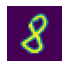

In [19]:
zeros = train_data[8]
fai.show_image(zeros[-1])

In [20]:
test_data = load_mnist(path/'testing')

100%|██████████| 10/10 [00:02<00:00,  4.34it/s]


In [21]:
len(test_data[0]), test_data[0].shape

(980, torch.Size([980, 28, 28]))

<AxesSubplot:>

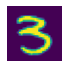

In [22]:
nines = test_data[3]
fai.show_image(nines[0])

### Baseline Model: Pixel Similarity

In [23]:
# take the mean across the samples dimension (i.e., average each pixel from all
# images in the stack for each digit)
means = torch.stack([digit_stack.mean(dim=0) for digit_stack in train_data])

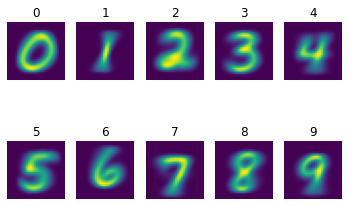

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5)
for i in range(0, 5):
    fai.show_image(means[i], ax=ax[0][i], title=i)
    fai.show_image(means[i+5], ax=ax[1][i], title=i+5)

In [25]:
def mnist_distance(a, b):
    # the smaller the distance, the more likely it is that `a` is of the same class as `b`
    return (a-b).abs().mean((-1, -2))

In [26]:
test_data[0].shape, means.shape

(torch.Size([980, 28, 28]), torch.Size([10, 28, 28]))

We can compute the distance from each image in the test set to each of the means for each digit class by using broadcasting (which requires adding one dimension to each digit stack -- `digit_stack.unsqueeze(1)`):

In [27]:
distances = [mnist_distance(digit_stack.unsqueeze(1), means) for digit_stack in test_data]
len(distances), distances[0].shape

(10, torch.Size([980, 10]))

In [28]:
def is_digit_class(digit_class, arg):
    return arg == digit_class

In [29]:
classwise_accuracies = torch.stack([
    is_digit_class(tensor([digit]), digit_distances.argmin(1)).float().mean()
    for digit, digit_distances in enumerate(distances)
])
total_accuracy = classwise_accuracies.mean()

Baseline accuracy with pixel similarity is 66.1%


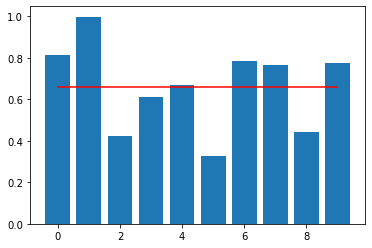

In [30]:
fig, ax = plt.subplots()
ax.bar(torch.arange(10), classwise_accuracies)
ax.plot(torch.arange(10), [total_accuracy] * 10, color='r')
print(f'Baseline accuracy with pixel similarity is {round(total_accuracy.item() * 100, 2)}%')

Digit class counts


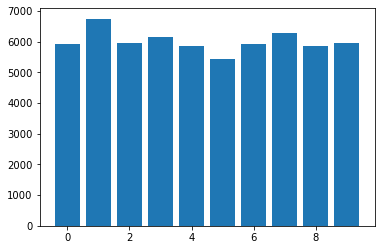

In [31]:
fig, ax = plt.subplots()
ax.bar(torch.arange(10), [train_data[i].shape[0] for i in range(len(train_data))])
print(f'Digit class counts')

In [32]:
train_data[0].shape

torch.Size([5923, 28, 28])

In [33]:
def create_dataset(data):
    """
    Stack all individual digit stacks into a single long stack of (x, y) samples.
    
    Assumes `data` is a list of tensors, each a stacked tensor of digits of a single class,
    in 2D format.
    """
    data_x, data_y = [], []
    for digit_class, digit_stack in enumerate(data):
        # turn each image in the stack into flat vectors
        data_x.extend(digit_stack.view(-1, digit_stack.shape[-1]*digit_stack.shape[-2]))
        data_y.extend([digit_class] * digit_stack.shape[0])
    data_y = tensor(data_y).view(-1, 1)
    data_x = torch.stack(data_x)
    return list(zip(data_x, data_y))

In [34]:
train_ds = create_dataset(train_data)
validation_ds = create_dataset(test_data)

x, y = train_ds[0]
x_validation, y_validation = validation_ds[0]
len(train_ds), len(validation_ds), x.shape, y.shape, x_validation.shape, y_validation.shape

(60000,
 10000,
 torch.Size([784]),
 torch.Size([1]),
 torch.Size([784]),
 torch.Size([1]))

In [36]:
train_dl = fai.DataLoader(train_ds, batch_size=256, shuffle=True)
validation_dl = fai.DataLoader(validation_ds, batch_size=256, shuffle=True)

x, y = fai.first(train_dl)
x_validation, y_validation = fai.first(validation_dl)
x.shape, y.shape, x_validation.shape, y_validation.shape

(torch.Size([256, 784]),
 torch.Size([256, 1]),
 torch.Size([256, 784]),
 torch.Size([256, 1]))

### Binary Model for Each Digit Class

In [37]:
def make_dataset_for(target_digit_class, data):
    data_x, data_y = [], []
    
    # include all of the samples from the target class at the beginning;
    # during training, this will be shuffled, so it's okay to do it this way...
    target_stack = data[target_digit_class]
    data_x.extend(target_stack.view(-1, target_stack.shape[-1]*target_stack.shape[-2]))
    data_y.extend([True] * target_stack.shape[0])

    non_target_data = data[:target_digit_class] + data[target_digit_class+1:]
    for digit_stack in non_target_data:
        # sample a fraction from each non-target digit class to balance
        indices = torch.multinomial(
            torch.arange(len(digit_stack)).float(), 
            int(digit_stack.shape[0] / 10)
        )
        # turn each image into a flat vector
        data_x.extend(digit_stack[indices].view(-1, digit_stack.shape[-1]*digit_stack.shape[-2]))
        data_y.extend([False] * indices.shape[0])

    data_y = tensor(data_y).view(-1, 1)
    data_x = torch.stack(data_x)
    return list(zip(data_x, data_y))

In [38]:
def make_dataloader_for(digit_class, data, batch_size=256, shuffle=True):
    dataset = make_dataset_for(digit_class, data)
    loader = fai.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

### Class Imbalance Check
During my first attempt at building this ensemble of binary classifiers, I was getting a constant accuracy value during training. After some digging, I realized the issue was that of class imbalance. The following is a check to ensure that this is no longer the case:

In [39]:
from collections import defaultdict

loader = make_dataloader_for(0, test_data)

digit_class_count = defaultdict(int)
total_samples = 0
for x_batch, y_batch in loader:
    total_samples += x_batch.shape[0]
    for y in y_batch:
        digit_class_count[y.item()] += 1
        
print(total_samples)
print(digit_class_count)

1878
defaultdict(<class 'int'>, {True: 980, False: 898})


In [40]:
def make_binary_classifier_model():
    return nn.Sequential(
        fai.Flatten(),
        nn.Linear(in_features=28*28, out_features=1),
        nn.Sigmoid()
    )

In [41]:
def mnist_binary_loss(predictions, targets):
    return torch.where(targets==True, 1.0-predictions, predictions).mean()

In [42]:
def batch_accuracy(predictions, targets):
    correct = ((predictions > 0.5) == targets)
    return correct.float().mean()

In [43]:
# Ensure that we're loading dataloaders properly
dataloaders = fai.DataLoaders(
    make_dataloader_for(0, train_data), 
    make_dataloader_for(0, test_data)
)
(sum(x.shape[0] for x,y in dataloaders.train),
 sum(x.shape[0] for x,y in dataloaders.valid))

(11327, 1878)

In [44]:
def train_binary_classifier_for(
    digit_class, train_data, test_data, epochs=10, learning_rate=1e-2
):
    print(f'training binary classifier for digit {digit_class}')
    dataloaders = fai.DataLoaders(
        make_dataloader_for(digit_class, train_data), 
        make_dataloader_for(digit_class, test_data, shuffle=False))
    
    model = make_binary_classifier_model()
    
    learner = fai.Learner(
        dataloaders, model, loss_func=mnist_binary_loss, metrics=[batch_accuracy])
    learner.fit(epochs, lr=learning_rate)
    
    return learner

In [45]:
# verify class proportions for each binary classifier
total_train = total_test = 0
for digit in range(10):
    print(len(train_data[digit]), len(test_data[digit]))
    total_train += len(train_data[digit])
    total_test += len(test_data[digit])
print(total_train, total_test)

5923 980
6742 1135
5958 1032
6131 1010
5842 982
5421 892
5918 958
6265 1028
5851 974
5949 1009
60000 10000


In [46]:
learners = {}
for digit_class in range(0, 10):
    learners[digit_class] = train_binary_classifier_for(digit_class, train_data, test_data)

training binary classifier for digit 0


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.118116,0.050414,0.970181,00:00
1,0.068490,0.034048,0.984558,00:00
2,0.049025,0.028856,0.982961,00:00
3,0.038643,0.023942,0.986156,00:00
4,0.032828,0.022082,0.986688,00:00
5,0.028985,0.019530,0.987753,00:00
6,0.026447,0.020814,0.987220,00:00
7,0.024387,0.017584,0.989350,00:00
8,0.022662,0.016686,0.989350,00:00
9,0.021566,0.016579,0.988818,00:00


training binary classifier for digit 1


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.085575,0.032564,0.983647,00:00
1,0.047958,0.023529,0.988107,00:00
2,0.036125,0.018956,0.990089,00:00
3,0.029547,0.017272,0.989594,00:00
4,0.025297,0.015519,0.990089,00:00
5,0.023157,0.014857,0.989594,00:00
6,0.022162,0.013597,0.990585,00:00
7,0.020452,0.012983,0.991080,00:00
8,0.019064,0.012264,0.991576,00:00
9,0.018415,0.013680,0.988107,00:00


training binary classifier for digit 2


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.148106,0.094543,0.929870,00:00
1,0.105373,0.078805,0.941299,00:00
2,0.086508,0.069612,0.950130,00:00
3,0.076217,0.065093,0.950130,00:00
4,0.070408,0.061257,0.950649,00:00
5,0.065099,0.058304,0.952727,00:00
6,0.062433,0.055629,0.954286,00:00
7,0.059806,0.053399,0.956883,00:00
8,0.056372,0.052730,0.955844,00:00
9,0.054210,0.051062,0.957922,00:00


training binary classifier for digit 3


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.160062,0.112484,0.912861,00:00
1,0.117001,0.094110,0.922310,00:00
2,0.098992,0.083625,0.933333,00:00
3,0.088648,0.075841,0.940157,00:00
4,0.081689,0.070838,0.943832,00:00
5,0.077589,0.069779,0.941207,00:00
6,0.074330,0.067021,0.943832,00:00
7,0.071547,0.065227,0.942782,00:00
8,0.069170,0.063119,0.944357,00:00
9,0.067439,0.063503,0.944882,00:00


training binary classifier for digit 4


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.137504,0.084851,0.935638,00:00
1,0.090274,0.063244,0.958511,00:00
2,0.069162,0.054324,0.960638,00:00
3,0.056973,0.050652,0.961170,00:00
4,0.049650,0.047552,0.964894,00:00
5,0.044749,0.044642,0.965957,00:00
6,0.041533,0.043225,0.967553,00:00
7,0.039773,0.041486,0.968085,00:00
8,0.037543,0.043520,0.962234,00:00
9,0.036079,0.039929,0.969149,00:00


training binary classifier for digit 5


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.205309,0.133402,0.912173,00:00
1,0.146844,0.106512,0.924402,00:00
2,0.123420,0.096122,0.926626,00:00
3,0.109735,0.088927,0.929405,00:00
4,0.100381,0.084467,0.931073,00:00
5,0.093437,0.082694,0.932185,00:00
6,0.088602,0.078412,0.935520,00:00
7,0.085462,0.076567,0.936076,00:00
8,0.082717,0.075070,0.937187,00:00
9,0.080932,0.073943,0.935520,00:00


training binary classifier for digit 6


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.110001,0.063088,0.956966,00:00
1,0.066195,0.051064,0.960194,00:00
2,0.050422,0.045601,0.963421,00:00
3,0.042000,0.042148,0.963959,00:00
4,0.037230,0.039858,0.967187,00:00
5,0.033757,0.037760,0.967187,00:00
6,0.031845,0.036263,0.967187,00:00
7,0.030772,0.035259,0.967187,00:00
8,0.029442,0.034500,0.967725,00:00
9,0.028806,0.034128,0.968800,00:00


training binary classifier for digit 7


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.117671,0.077877,0.947451,00:00
1,0.078722,0.061273,0.955255,00:00
2,0.062101,0.054673,0.958897,00:00
3,0.053361,0.051745,0.959938,00:00
4,0.048018,0.049410,0.959417,00:00
5,0.044042,0.046169,0.963059,00:00
6,0.042038,0.045272,0.960978,00:00
7,0.039841,0.043754,0.962539,00:00
8,0.037670,0.044747,0.962019,00:00
9,0.036642,0.041543,0.962539,00:00


training binary classifier for digit 8


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.222797,0.166582,0.867592,00:00
1,0.174461,0.142051,0.886813,00:00
2,0.152835,0.130261,0.893219,00:00
3,0.139643,0.123293,0.895355,00:00
4,0.130811,0.119848,0.900694,00:00
5,0.124770,0.115177,0.904965,00:00
6,0.120648,0.113292,0.903897,00:00
7,0.117608,0.111331,0.902296,00:00
8,0.114375,0.109037,0.906033,00:00
9,0.112535,0.107906,0.904965,00:00


training binary classifier for digit 9


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.176767,0.130613,0.882415,00:00
1,0.132295,0.110489,0.903412,00:00
2,0.110564,0.099997,0.911286,00:00
3,0.099399,0.094199,0.915486,00:00
4,0.090572,0.091743,0.916535,00:00
5,0.084753,0.088091,0.922835,00:00
6,0.081120,0.085744,0.925459,00:00
7,0.078366,0.084793,0.923360,00:00
8,0.074940,0.083246,0.923885,00:00
9,0.073506,0.081683,0.924409,00:00


In [47]:
with torch.no_grad():
    predictions = learners[0].model(test_data[0])
    print(predictions.mean())

tensor(0.9874)


In [48]:
with torch.no_grad():
    predictions = learners[1].model(test_data[1])
    print(predictions.mean())

tensor(0.9821)


In [53]:
def ensemble_predict(learners, inputs):
    for learner in learners.values():
        learner.model = learner.model.cuda()
        
    predictions = [learners[digit].model(inputs) for digit in range(10)]
    predictions = torch.stack(predictions).squeeze().permute(1, 0)
    # we may need to pass through a softmax layer if there are highly
    # confident predictions for more than one binary classifier in the
    return torch.softmax(predictions, dim=1).argmax(dim=1)
    #return (predictions > 0.85).float()

In [54]:
predictions = ensemble_predict(learners, test_data[1].cuda())
predictions.shape

torch.Size([1135])

In [55]:
def compute_accuracy(ensemble, validation_data):
    for learner in ensemble.values():
        learner.model = learner.model.cuda()
        
    hard_samples = []
    accuracies = []
    for inputs, targets in tqdm(validation_data):
        inputs = inputs.cuda()
        predictions = ensemble_predict(ensemble, inputs)
        accuracies.append((predictions == targets).float().mean())
        if accuracies[-1] < 0.85:
            hard_samples.append((inputs, targets))
    return tensor(accuracies).mean(), hard_samples

In [56]:
mean, hard_samples = compute_accuracy(learners, loaders.valid)
mean

100%|██████████| 157/157 [00:02<00:00, 60.16it/s]


tensor(0.8992)

Even though the result is not bad at ~90% accuracy (compared to 92% of the single network above), it is important to analyze the mistakes made by this ensemble and see if we can improve on it:

In [57]:
len(hard_samples)

30

In [58]:
from collections import defaultdict

hard_samples_by_class = defaultdict(int)
for inputs, targets in hard_samples:
    for digit_class in range(10):
        hard_samples_by_class[digit_class] += (targets == digit_class).sum().item()

print(hard_samples_by_class)

defaultdict(<class 'int'>, {0: 0, 1: 0, 2: 448, 3: 0, 4: 256, 5: 768, 6: 0, 7: 128, 8: 256, 9: 64})


<BarContainer object of 10 artists>

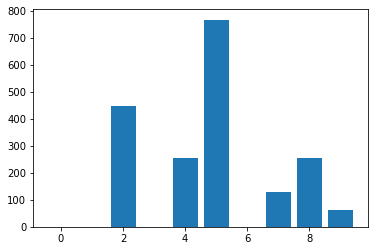

In [59]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.bar(torch.arange(10), hard_samples_by_class.values())

It is interesting to notice that most classification errors were made on the number 5, followed by the numbers 2 and 8.

In [60]:
x, y = hard_samples[5]
x.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

<AxesSubplot:>

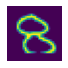

In [62]:
yhat = ensemble_predict(learners, x)
mistakes = x[y != yhat]
fai.show_image(mistakes[0])

<AxesSubplot:>

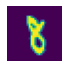

In [63]:
fai.show_image(mistakes[-1])